## Prepare data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from aeon.datasets import load_classification
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Load Time Series dataset
def load_data(dataset):
    X_train, y_train = load_classification(dataset, split="train")
    X_test0, y_test0 = load_classification(dataset, split="test")
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_test0 = le.fit_transform(y_test0)    

    return X_train, y_train, X_test0, y_test0

# Load dataset
dataset = "WalkingSittingStanding"      # Also tested for PenDigits
x_train, y_train, X_test0, y_test0 = load_data(dataset)
n_timesteps, n_features, n_outputs = x_train.shape[2], x_train.shape[1], len(np.unique(y_train))
num_classes = len(np.unique(y_train))
batch_size=128
num_epochs = 100
len_steal = 5000


# One-hot encode labels
y_train = to_categorical(y_train, num_classes=n_outputs)
y_test0 = to_categorical(y_test0, num_classes=n_outputs)

2025-01-01 20:22:45.307579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735759365.325132   17906 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735759365.330600   17906 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-01 20:22:45.347367: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train and test model

In [2]:
from keras.callbacks import EarlyStopping

# Define the model architecture
def get_CNN_Model(n_timesteps, n_features, n_outputs):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_features, n_timesteps), padding='same'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Fixed loss function
    return model

# Initialize model
cnn_model = get_CNN_Model(n_timesteps, n_features, n_outputs)

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       
    patience=10,              
    restore_best_weights=True 
)

# Train the model
history = cnn_model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test0, y_test0)
print(f"Test accuracy: {cnn_test_accuracy:.4f}")


Epoch 1/100


/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1735759371.201681   17906 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4148 - loss: 1.3849 - val_accuracy: 0.5992 - val_loss: 0.9283
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5878 - loss: 0.9498 - val_accuracy: 0.6603 - val_loss: 0.8360
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6626 - loss: 0.8365 - val_accuracy: 0.8057 - val_loss: 0.5970
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7791 - loss: 0.5873 - val_accuracy: 0.8003 - val_loss: 0.4916
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8046 - loss: 0.4946 - val_accuracy: 0.8451 - val_loss: 0.4050
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8319 - loss: 0.4106 - val_accuracy: 0.8832 - val_loss: 0.3371
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8586 - loss: 0.3524 - val_accuracy: 0.8832 - val_loss: 0.3039
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8792 - loss: 0.3114 - val_accuracy: 0.8981 - val_loss: 0.2

## Define original Classifier and run attacks

In [3]:
from art.attacks import ExtractionAttack
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import TensorFlowV2Classifier

classifier_original = TensorFlowV2Classifier(cnn_model, clip_values=(0, 1), nb_classes=num_classes, input_shape=(batch_size, n_features, n_timesteps))
    

attack_catalogue = {"Probabilistic CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax CopycatCNN": CopycatCNN(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                    "Probabilistic KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=True),
                    "Argmax KnockoffNets": KnockoffNets(classifier=classifier_original,
                                              batch_size_fit=64,
                                              batch_size_query=64,
                                              nb_epochs=num_epochs,
                                              nb_stolen=len_steal,
                                              use_probability=False),
                   }

results = []
percentages = [0.001, 0.005, 0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]  # Generate percentages of samples to run the attacks on

for percentage in percentages:
    len_steal = int(len(X_test0) * percentage) 
    print(f'running attack for {len_steal} samples')
    indices = np.random.permutation(len(X_test0))
    x_steal = X_test0[indices[:len_steal]]
    y_steal = y_test0[indices[:len_steal]]
    x_test = X_test0[indices[len_steal:]]
    y_test = y_test0[indices[len_steal:]]

    for name, attack in attack_catalogue.items():
        model_stolen = get_CNN_Model(n_timesteps, n_features, n_outputs)
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        optimizer = tf.keras.optimizers.Adam()

        classifier_stolen = TensorFlowV2Classifier(
            model=model_stolen,
            clip_values=(0, 1),
            nb_classes=n_outputs,
            input_shape=(n_timesteps, n_features),
            loss_object=loss_object,
            optimizer=optimizer
        )
        classifier_stolen = attack.extract(x_steal, y_steal, thieved_classifier=classifier_stolen)
        acc = classifier_stolen._model.evaluate(x_test, y_test)[1]
        print(name, ":", acc)
        results.append((name, len_steal, acc))

/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")
/home/fabian/GitHub/art_extraction/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


running attack for 2 samples


2025-01-01 20:23:02.572654: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.575705: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.580610: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.591264: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.612472: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.652123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-01 20:23:02.733084: I tensorflow/core/framework/local_rendezvous.cc:405] L

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2299 - loss: 5.0843 
Probabilistic CopycatCNN : 0.22818335890769958


2025-01-01 20:23:03.741149: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.2306 - loss: 7.4262
Argmax CopycatCNN : 0.22852292656898499


2025-01-01 20:23:04.871970: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2299 - loss: 5.8254  
Probabilistic KnockoffNets : 0.22818335890769958
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2299 - loss: 7.9123  
Argmax KnockoffNets : 0.22818335890769958
running attack for 14 samples
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.4966 - loss: 1.5623
Probabilistic CopycatCNN : 0.502557098865509


2025-01-01 20:23:08.316121: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4585 - loss: 2.5389  
Argmax CopycatCNN : 0.47596317529678345
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4672 - loss: 1.6839  
Probabilistic KnockoffNets : 0.47698602080345154
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4681 - loss: 2.8193  
Argmax KnockoffNets : 0.4742584526538849
running attack for 29 samples
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5040 - loss: 1.8960  
Probabilistic CopycatCNN : 0.5102810263633728
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.4935 - loss: 2.1760
Argmax CopycatCNN : 0.49828648567199707


2025-01-01 20:23:13.929181: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4937 - loss: 2.0187  
Probabilistic KnockoffNets : 0.5006853938102722
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.4999 - loss: 2.0820
Argmax KnockoffNets : 0.5075393915176392
running attack for 147 samples
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6799 - loss: 0.9629
Probabilistic CopycatCNN : 0.6803571581840515
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - accuracy: 0.6630 - loss: 1.3030
Argmax CopycatCNN : 0.664642870426178
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.7030 - loss: 0.8182
Probabilistic KnockoffNets : 0.6971428394317627
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 1.4037  
Argmax KnockoffNets : 0.6628571152687073
running attack for 294 samples
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6965 - loss: 0.9664
Probabilistic CopycatCNN : 0.6965699195861816
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7080 - loss: 1.4389  
Argmax CopycatCNN : 0.7078778

2025-01-01 20:23:31.848368: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7641 - loss: 0.6974  
Probabilistic CopycatCNN : 0.7596806287765503
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.7499 - loss: 1.4614
Argmax CopycatCNN : 0.750099778175354
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7843 - loss: 0.6505
Probabilistic KnockoffNets : 0.7704590559005737
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7277 - loss: 1.6485
Argmax KnockoffNets : 0.7229540944099426
running attack for 589 samples
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7832 - loss: 0.7182  
Probabilistic CopycatCNN : 0.7786259651184082
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7754 - loss: 1.4681  
Argmax CopycatCNN : 0.7832909226417542
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7677 - loss: 0.7513  
Probabilistic KnockoffNets : 0.7807464003562927
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.7580 - loss: 1.5101
Argmax KnockoffNets : 0.7718405723571777
running attack for 736

2025-01-01 20:24:34.726428: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7992 - loss: 0.5692  
Probabilistic CopycatCNN : 0.8049745559692383
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7953 - loss: 1.4845  
Argmax CopycatCNN : 0.8061051368713379
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8100 - loss: 0.5593
Probabilistic KnockoffNets : 0.8106274604797363
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7856 - loss: 1.3619   
Argmax KnockoffNets : 0.794234037399292
running attack for 1326 samples
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8348 - loss: 0.5577  
Probabilistic CopycatCNN : 0.811844527721405
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8069 - loss: 1.5231  
Argmax CopycatCNN : 0.7859346270561218
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8159 - loss: 0.6034  
Probabilistic KnockoffNets : 0.7902529239654541
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 1.4564  
Argmax KnockoffNets : 0.7927205562591553
running attack for 14

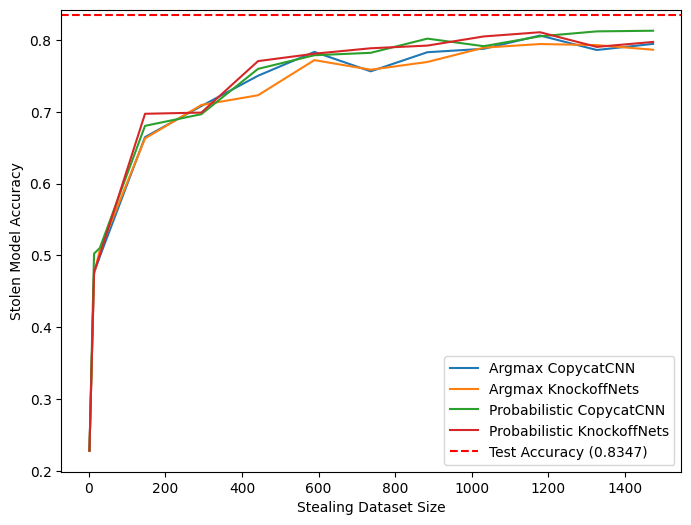

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results, columns=('Method Name', 'Stealing Dataset Size', 'Accuracy'))
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("Stealing Dataset Size")
ax.set_ylabel("Stolen Model Accuracy")
for name, group in df.groupby("Method Name"):
    group.plot(1, 2, ax=ax, label=name)
    
ax.axhline(y=cnn_test_accuracy, color='r', linestyle='--', 
            label=f"Test Accuracy ({cnn_test_accuracy:.4f})")
ax.legend()
plt.show()